Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [23]:
import time
t = time.time()

batch_size = 256
learning_rate = 0.5
n_hidden_1 = 256
n_hidden_2 = 256
num_steps = 5001
weights_penalty = 0.001

def multilayer_model(x, weights, biases):
    # Hidden layer
    layer_1 = tf.add(tf.matmul(x, weights['l1']), biases['l1'])
    layer_1 = tf.nn.relu(layer_1)
    #layer_2 = tf.add(tf.matmul(layer_1, weights['l2']), biases['l2'])
    #layer_2 = tf.nn.relu(layer_2)
    y = tf.add(tf.matmul(layer_1, weights['out']), biases['out'])
    return y
    

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables.
    weights = {
        'l1': tf.Variable(tf.random_normal([image_size * image_size, n_hidden_1])),
        'l2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
        'out': tf.Variable(tf.random_normal([n_hidden_2, num_labels]))
    }
    biases = {
        'l1': tf.Variable(tf.random_normal([n_hidden_1])),
        'l2': tf.Variable(tf.random_normal([n_hidden_2])),
        'out': tf.Variable(tf.random_normal([num_labels]))
    }
    
    # Training computation.
    logits = multilayer_model(tf_train_dataset, weights, biases)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)
                          + weights_penalty*tf.nn.l2_loss(weights['l1'])
                          #+ weights_penalty*tf.nn.l2_loss(weights['l2'])
                         + weights_penalty*tf.nn.l2_loss(weights['out']))
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    #optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(multilayer_model(tf_valid_dataset, weights, biases))
    test_prediction = tf.nn.softmax(multilayer_model(tf_test_dataset, weights, biases))

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

elapsed = time.time() - t
print('Elasped: %s' % elapsed)

Initialized
Minibatch loss at step 0: 326.427460
Minibatch accuracy: 9.0%
Validation accuracy: 31.5%
Minibatch loss at step 500: 65.923042
Minibatch accuracy: 77.0%
Validation accuracy: 76.6%
Minibatch loss at step 1000: 37.085938
Minibatch accuracy: 78.5%
Validation accuracy: 80.9%
Minibatch loss at step 1500: 22.250946
Minibatch accuracy: 82.8%
Validation accuracy: 83.5%
Minibatch loss at step 2000: 13.808878
Minibatch accuracy: 76.6%
Validation accuracy: 84.7%
Minibatch loss at step 2500: 8.489998
Minibatch accuracy: 84.0%
Validation accuracy: 85.4%
Minibatch loss at step 3000: 5.262975
Minibatch accuracy: 85.5%
Validation accuracy: 86.5%
Minibatch loss at step 3500: 3.332768
Minibatch accuracy: 87.5%
Validation accuracy: 87.5%
Minibatch loss at step 4000: 2.173202
Minibatch accuracy: 89.8%
Validation accuracy: 88.0%
Minibatch loss at step 4500: 1.449038
Minibatch accuracy: 91.0%
Validation accuracy: 88.8%
Minibatch loss at step 5000: 1.157944
Minibatch accuracy: 87.5%
Validation ac

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [34]:
import time
t = time.time()

batch_size = 256
learning_rate = 0.5
n_hidden_1 = 256
n_hidden_2 = 256
num_steps = 10001
weights_penalty = 0.001
dropout_rate = 0.8

def train_model(x, weights, biases):
    # Hidden layer
    layer_1 = tf.add(tf.matmul(x, weights['l1']), biases['l1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_1 = tf.nn.dropout(layer_1, dropout_rate)
    #layer_2 = tf.add(tf.matmul(layer_1, weights['l2']), biases['l2'])
    #layer_2 = tf.nn.relu(layer_2)
    y = tf.add(tf.matmul(layer_1, weights['out']), biases['out'])
    return y
    
def evaluate_model(x, weights, biases):
    # Hidden layer
    layer_1 = tf.add(tf.matmul(x, weights['l1']), biases['l1'])
    layer_1 = tf.nn.relu(layer_1)
    #layer_2 = tf.add(tf.matmul(layer_1, weights['l2']), biases['l2'])
    #layer_2 = tf.nn.relu(layer_2)
    y = tf.add(tf.matmul(layer_1, weights['out']), biases['out'])
    return y
    
    
graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables.
    weights = {
        'l1': tf.Variable(tf.random_normal([image_size * image_size, n_hidden_1])),
        'l2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
        'out': tf.Variable(tf.random_normal([n_hidden_2, num_labels]))
    }
    biases = {
        'l1': tf.Variable(tf.random_normal([n_hidden_1])),
        'l2': tf.Variable(tf.random_normal([n_hidden_2])),
        'out': tf.Variable(tf.random_normal([num_labels]))
    }
    
    # Training computation.
    logits = train_model(tf_train_dataset, weights, biases)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)
                          + weights_penalty*tf.nn.l2_loss(weights['l1'])
                          #+ weights_penalty*tf.nn.l2_loss(weights['l2'])
                         + weights_penalty*tf.nn.l2_loss(weights['out']))
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    #optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(evaluate_model(tf_valid_dataset, weights, biases))
    test_prediction = tf.nn.softmax(evaluate_model(tf_test_dataset, weights, biases))

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

elapsed = time.time() - t
print('Elasped: %s' % elapsed)

Initialized
Minibatch loss at step 0: 359.431946
Minibatch accuracy: 9.4%
Validation accuracy: 34.6%
Minibatch loss at step 500: 63.832409
Minibatch accuracy: 72.3%
Validation accuracy: 77.7%
Minibatch loss at step 1000: 37.341629
Minibatch accuracy: 74.2%
Validation accuracy: 80.0%
Minibatch loss at step 1500: 22.336929
Minibatch accuracy: 82.8%
Validation accuracy: 83.0%
Minibatch loss at step 2000: 13.773964
Minibatch accuracy: 78.5%
Validation accuracy: 84.3%
Minibatch loss at step 2500: 8.532104
Minibatch accuracy: 82.0%
Validation accuracy: 85.2%
Minibatch loss at step 3000: 5.287638
Minibatch accuracy: 84.8%
Validation accuracy: 86.3%
Minibatch loss at step 3500: 3.334022
Minibatch accuracy: 87.5%
Validation accuracy: 87.0%
Minibatch loss at step 4000: 2.221980
Minibatch accuracy: 87.5%
Validation accuracy: 87.4%
Minibatch loss at step 4500: 1.477416
Minibatch accuracy: 89.1%
Validation accuracy: 88.1%
Minibatch loss at step 5000: 1.161316
Minibatch accuracy: 86.7%
Validation ac

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


Initialized
Minibatch loss at step 0: 122.521553
Minibatch accuracy: 9.8%
Validation accuracy: 10.0%
Minibatch loss at step 500: 6.669133
Minibatch accuracy: 65.2%
Validation accuracy: 79.3%
Minibatch loss at step 1000: 6.257179
Minibatch accuracy: 74.5%
Validation accuracy: 82.0%
Minibatch loss at step 1500: 6.111706
Minibatch accuracy: 77.2%
Validation accuracy: 83.4%
Minibatch loss at step 2000: 6.026469
Minibatch accuracy: 78.1%
Validation accuracy: 84.3%
Minibatch loss at step 2500: 5.914476
Minibatch accuracy: 80.9%
Validation accuracy: 84.4%
Minibatch loss at step 3000: 5.878120
Minibatch accuracy: 80.2%
Validation accuracy: 85.0%
Minibatch loss at step 3500: 5.767183
Minibatch accuracy: 81.4%
Validation accuracy: 85.3%
Minibatch loss at step 4000: 5.637526
Minibatch accuracy: 82.9%
Validation accuracy: 85.5%
Minibatch loss at step 4500: 5.672501
Minibatch accuracy: 81.2%
Validation accuracy: 85.8%
Minibatch loss at step 5000: 5.614084
Minibatch accuracy: 82.0%
Validation accura

Validation accuracy: 91.1%
Minibatch loss at step 45000: 2.537522
Minibatch accuracy: 90.9%
Validation accuracy: 91.1%
Minibatch loss at step 45500: 2.515697
Minibatch accuracy: 91.1%
Validation accuracy: 91.1%
Minibatch loss at step 46000: 2.500481
Minibatch accuracy: 91.2%
Validation accuracy: 91.2%
Minibatch loss at step 46500: 2.477502
Minibatch accuracy: 91.8%
Validation accuracy: 91.1%
Minibatch loss at step 47000: 2.429268
Minibatch accuracy: 91.9%
Validation accuracy: 91.3%
Minibatch loss at step 47500: 2.448547
Minibatch accuracy: 91.0%
Validation accuracy: 91.2%
Minibatch loss at step 48000: 2.405909
Minibatch accuracy: 90.5%
Validation accuracy: 91.2%
Minibatch loss at step 48500: 2.405702
Minibatch accuracy: 90.6%
Validation accuracy: 91.2%
Minibatch loss at step 49000: 2.347272
Minibatch accuracy: 92.3%
Validation accuracy: 91.2%
Minibatch loss at step 49500: 2.338198
Minibatch accuracy: 91.9%
Validation accuracy: 91.4%
Minibatch loss at step 50000: 2.312493
Minibatch accu

Minibatch loss at step 89500: 1.092338
Minibatch accuracy: 95.9%
Validation accuracy: 92.5%
Minibatch loss at step 90000: 1.066044
Minibatch accuracy: 96.6%
Validation accuracy: 92.4%
Minibatch loss at step 90500: 1.076127
Minibatch accuracy: 96.2%
Validation accuracy: 92.3%
Minibatch loss at step 91000: 1.089172
Minibatch accuracy: 95.4%
Validation accuracy: 92.5%
Minibatch loss at step 91500: 1.081874
Minibatch accuracy: 94.7%
Validation accuracy: 92.4%
Minibatch loss at step 92000: 1.030706
Minibatch accuracy: 96.6%
Validation accuracy: 92.4%
Minibatch loss at step 92500: 1.042050
Minibatch accuracy: 96.0%
Validation accuracy: 92.4%
Minibatch loss at step 93000: 1.020159
Minibatch accuracy: 96.7%
Validation accuracy: 92.5%
Minibatch loss at step 93500: 1.042976
Minibatch accuracy: 95.8%
Validation accuracy: 92.6%
Minibatch loss at step 94000: 1.002438
Minibatch accuracy: 96.6%
Validation accuracy: 92.6%
Minibatch loss at step 94500: 1.004008
Minibatch accuracy: 95.5%
Validation accu

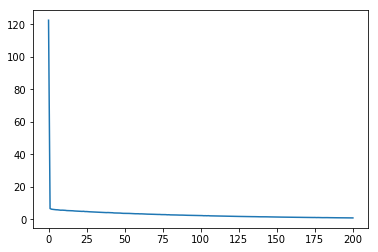

In [18]:
import time
import matplotlib.pyplot as plt
t = time.time()
loss_series = []

batch_size = 1024
initial_learning_rate = 0.1
decay_rate = 0.96
n_hidden_1 = 4096
n_hidden_2 = 2048
n_hidden_3 = 1024
num_steps = 100001
weights_penalty = 0.0001
dropout_rate = 0.5

def train_model(x, weights, biases):
    # Hidden layer
    linear = tf.add(tf.matmul(x, weights['l1']), biases['l1'])
    relu = tf.nn.relu(linear)
    dropout = tf.nn.dropout(relu, dropout_rate)
    
    linear = tf.add(tf.matmul(dropout, weights['l2']), biases['l2'])
    relu = tf.nn.relu(linear)
    dropout = tf.nn.dropout(relu, dropout_rate)
    
    linear = tf.add(tf.matmul(dropout, weights['l3']), biases['l3'])
    relu = tf.nn.relu(linear)
    dropout = tf.nn.dropout(relu, dropout_rate)
    
    y = tf.add(tf.matmul(dropout, weights['out']), biases['out'])
    return y
    
def evaluate_model(x, weights, biases):
    # Hidden layer
    linear = tf.add(tf.matmul(x, weights['l1']), biases['l1'])
    relu = tf.nn.relu(linear)
    
    linear = tf.add(tf.matmul(relu, weights['l2']), biases['l2'])
    relu = tf.nn.relu(linear)
    
    linear = tf.add(tf.matmul(relu, weights['l3']), biases['l3'])
    relu = tf.nn.relu(linear)
    
    y = tf.add(tf.matmul(relu, weights['out']), biases['out'])
    return y
    
    
graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables.
    weights = {
        'l1': tf.Variable(tf.truncated_normal([image_size * image_size, n_hidden_1], stddev=0.1)),
        'l2': tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2], stddev=0.1)),
        'l3': tf.Variable(tf.truncated_normal([n_hidden_2, n_hidden_3], stddev=0.1)),
        'out': tf.Variable(tf.truncated_normal([n_hidden_3, num_labels], stddev=0.1))
    }
    biases = {
        'l1': tf.Variable(tf.zeros([n_hidden_1])),
        'l2': tf.Variable(tf.zeros([n_hidden_2])),
        'l3': tf.Variable(tf.zeros([n_hidden_3])),
        'out': tf.Variable(tf.zeros([num_labels]))
    }
    
    # Training computation.
    logits = train_model(tf_train_dataset, weights, biases)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)
                          + weights_penalty*tf.nn.l2_loss(weights['l1'])
                          + weights_penalty*tf.nn.l2_loss(weights['l2'])
                          + weights_penalty*tf.nn.l2_loss(weights['l3'])
                          + weights_penalty*tf.nn.l2_loss(weights['out']))
    
    # Optimizer.
    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step, num_steps, decay_rate)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    #optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(evaluate_model(tf_valid_dataset, weights, biases))
    test_prediction = tf.nn.softmax(evaluate_model(tf_test_dataset, weights, biases))

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            loss_series.append(l)
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

elapsed = time.time() - t
print('Elasped: %s' % elapsed)

plt.plot(loss_series)
plt.show()